# Crime Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tabulate import tabulate
from scipy.stats import norm, gamma, weibull_min
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
import altair as alt
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [2]:
df = pd.read_csv("/Users/nayemontiel18/Library/CloudStorage/OneDrive-UBC/UBCO/MDS/BLOCK5/Data583/Project/Other files/Crime_Data_from_2020_to_Present.csv", parse_dates=['Date Rptd','DATE OCC'])
# Convert the 'Time' column to datetime format
df['TIME_OCCURRENCE'] = df['TIME OCC'].astype(str).str.zfill(4)
df['TIME_OCCURRENCE'] = pd.to_datetime(df['TIME_OCCURRENCE'], format='%H%M')
# Extract the Year and Month from the 'DATE OCC' column
df['Year'] = df['DATE OCC'].dt.year
df['Month'] = df['DATE OCC'].dt.month
df.shape

(892934, 31)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892934 entries, 0 to 892933
Data columns (total 31 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   DR_NO            892934 non-null  int64         
 1   Date Rptd        892934 non-null  datetime64[ns]
 2   DATE OCC         892934 non-null  datetime64[ns]
 3   TIME OCC         892934 non-null  int64         
 4   AREA             892934 non-null  int64         
 5   AREA NAME        892934 non-null  object        
 6   Rpt Dist No      892934 non-null  int64         
 7   Part 1-2         892934 non-null  int64         
 8   Crm Cd           892934 non-null  int64         
 9   Crm Cd Desc      892934 non-null  object        
 10  Mocodes          768605 non-null  object        
 11  Vict Age         892934 non-null  int64         
 12  Vict Sex         774633 non-null  object        
 13  Vict Descent     774625 non-null  object        
 14  Premis Cd        892

# Missing Values

In [4]:
print("The percentage of missing values by column is:\n", (df.isnull().sum()/len(df))*100)

The percentage of missing values by column is:
 DR_NO               0.000000
Date Rptd           0.000000
DATE OCC            0.000000
TIME OCC            0.000000
AREA                0.000000
AREA NAME           0.000000
Rpt Dist No         0.000000
Part 1-2            0.000000
Crm Cd              0.000000
Crm Cd Desc         0.000000
Mocodes            13.923649
Vict Age            0.000000
Vict Sex           13.248572
Vict Descent       13.249467
Premis Cd           0.001120
Premis Desc         0.061371
Weapon Used Cd     65.334616
Weapon Desc        65.334616
Status              0.000000
Status Desc         0.000000
Crm Cd 1            0.001232
Crm Cd 2           92.711779
Crm Cd 3           99.753621
Crm Cd 4           99.992945
LOCATION            0.000000
Cross Street       84.211599
LAT                 0.000000
LON                 0.000000
TIME_OCCURRENCE     0.000000
Year                0.000000
Month               0.000000
dtype: float64


# Duplicates

In [5]:
df.duplicated().sum()

0

# Droping columns and rows with NA's

In [6]:
# 1. Removing the rows with Premis Desc, Vict Sex and Vict Descent equal to NA
df_clean = df.dropna(subset=['Vict Sex', 'Vict Descent', 'Premis Desc'])

# 2. Removing rows with age lower or equal than zero
df_clean = df_clean[df_clean['Vict Age'] > 0]

# 3. Replacing 'Crm Cd 1' NA's values with 'Crm Cd'

# Identify the indexes of missing values in 'Crm Cd 1' column
missing_indexes = df_clean[df_clean['Crm Cd 1'].isna()].index
# Replace missing values in 'Crm Cd 1' column with corresponding values from 'Crm Cd'
df_clean.loc[missing_indexes, 'Crm Cd 1'] = df_clean.loc[missing_indexes, 'Crm Cd']

# 4. Removing rows with LAT and Lon equal to zero

# Get the index of rows where both 'LAT' and 'LON' are equal to 0
index_to_drop = df_clean[(df_clean['LAT'] == 0) & (df_clean['LON'] == 0)].index

# Drop the rows with the specified index
df_clean.drop(index=index_to_drop, inplace=True)

# 5. Removing columns 
df_clean = df_clean.drop(columns=['Part 1-2', 'Mocodes', 'Weapon Used Cd', 'Weapon Desc', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'Cross Street',
                 'AREA', 'Status'])

# Data clean: shape and missing values

In [7]:
print("Data shape\n", df_clean.shape)
print("\nMissing values\n", df_clean.isna().sum())

Data shape
 (666842, 21)

Missing values
 DR_NO              0
Date Rptd          0
DATE OCC           0
TIME OCC           0
AREA NAME          0
Rpt Dist No        0
Crm Cd             0
Crm Cd Desc        0
Vict Age           0
Vict Sex           0
Vict Descent       0
Premis Cd          0
Premis Desc        0
Status Desc        0
Crm Cd 1           0
LOCATION           0
LAT                0
LON                0
TIME_OCCURRENCE    0
Year               0
Month              0
dtype: int64


# Exporting clean data 

In [8]:
#df_clean.to_csv('clean_data.csv', index=False)

# Victim features

In [9]:
df_clean['Vict Age'].describe().round(2)

count    666842.00
mean         39.58
std          15.60
min           2.00
25%          28.00
50%          37.00
75%          50.00
max          99.00
Name: Vict Age, dtype: float64

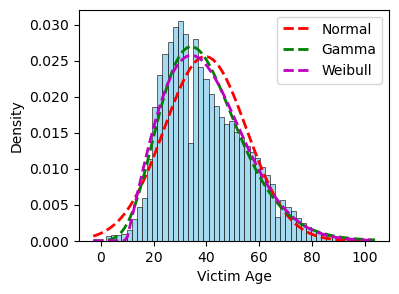

In [10]:
# Set up the figure and axes
plt.figure(figsize=(4, 3))

# Plot the histogram
sns.histplot(df_clean['Vict Age'], bins=50, color='skyblue', edgecolor='black', kde=False, stat='density')

# Fit a normal distribution to the data
mu, std = norm.fit(df_clean['Vict Age'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p_normal = norm.pdf(x, mu, std)

# Plot the normal curve
plt.plot(x, p_normal, 'r--', label='Normal', linewidth=2)

# Fit a gamma distribution to the data
params_gamma = gamma.fit(df_clean['Vict Age'])
p_gamma = gamma.pdf(x, *params_gamma)

# Plot the gamma curve
plt.plot(x, p_gamma, 'g--', label='Gamma', linewidth=2)

# Fit a Weibull distribution to the data
params_weibull = weibull_min.fit(df_clean['Vict Age'])
p_weibull = weibull_min.pdf(x, *params_weibull)

# Plot the Weibull curve
plt.plot(x, p_weibull, 'm--', label='Weibull', linewidth=2)

# Add legend
plt.legend()

# Add labels and title
plt.title('')
plt.xlabel('Victim Age')
plt.ylabel('Density')

# Show plot
plt.show()

In [11]:
np.sort(df_clean['Vict Age'].unique())

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

## Premis Desc: The type of structure, vehicle, or location where the crime took place.

In [12]:
df_clean['Premis Desc'].nunique()

303

In [13]:
# Assuming df_clean is your DataFrame
table_data = round(df_clean['Premis Desc'].value_counts(normalize=True).head(15),3)*100

# Convert table data to a DataFrame for tabulation
table_df = pd.DataFrame(table_data).reset_index()
table_df.columns = ['Premis Desc', 'Percentage']
table_df = table_df.rename(columns={'Premis Desc': 'Crime Place', 'Percentage': 'Percentage'})
# Display the table using tabulate
print(tabulate(table_df, headers='keys', tablefmt='fancy_grid', showindex=False))

╒══════════════════════════════════════════════╤══════════════╕
│ Crime Place                                  │   Percentage │
╞══════════════════════════════════════════════╪══════════════╡
│ SINGLE FAMILY DWELLING                       │         22.1 │
├──────────────────────────────────────────────┼──────────────┤
│ STREET                                       │         18.5 │
├──────────────────────────────────────────────┼──────────────┤
│ MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC) │         15.6 │
├──────────────────────────────────────────────┼──────────────┤
│ PARKING LOT                                  │          6.4 │
├──────────────────────────────────────────────┼──────────────┤
│ SIDEWALK                                     │          5.3 │
├──────────────────────────────────────────────┼──────────────┤
│ VEHICLE, PASSENGER/TRUCK                     │          3.7 │
├──────────────────────────────────────────────┼──────────────┤
│ OTHER BUSINESS                        

In [14]:
crime_place_original = df_clean.groupby('Premis Desc').size().sort_values(ascending=False).reset_index(name='COUNT')
alt.Chart(crime_place_original.iloc[1:20,], title='Location where the crime took place').mark_bar(color='black').encode(
    alt.X('COUNT', title=''),
    alt.Y('Premis Desc', sort='x', title='')
)

alt.Chart(...)

In [15]:
# Define conditions and corresponding values
conditions = [
    df_clean['Premis Desc'] == 'SINGLE FAMILY DWELLING',
    df_clean['Premis Desc'] == 'MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)',
    df_clean['Premis Desc'].isin(['STREET', 'SIDEWALK', 'ALLEY', 'PARK/PLAYGROUND']),
    df_clean['Premis Desc'].isin(['VEHICLE, PASSENGER/TRUCK', 'TRANSPORTATION FACILITY (AIRPORT)', 'MTA BUS', 'BUS STOP', 'LA UNION STATION (NOT LINE SPECIFIC)']),
    df_clean['Premis Desc'].isin(['PARKING LOT', 'GARAGE/CARPORT', 'DRIVEWAY', 'PARKING', 'PORCH, RESIDENTIAL', 'PARKING UNDERGROUND/BUILDING',
                                  'OTHER/OUTSIDE']),
    df_clean['Premis Desc'].isin(['OTHER BUSINESS', 'RESTAURANT/FAST FOOD', 'DEPARTMENT STORE', 'HOTEL', 'MARKET', 'YARD (RESIDENTIAL/BUSINESS)',
                                  'CLOTHING STORE', 'GAS STATION','PUBLIC STORAGE', 'BANK', 'OTHER STORE', 'MOTEL', 'AUTOMATED TELLER MACHINE (ATM)',
                                  'MINI-MART', 'DRUG STORE', 'HEALTH SPA/GYM', 'LIQUOR STORE', 'SHOPPING MALL (COMMON AREA)', 'LAUNDROMAT',
                                  "COFFEE SHOP (STARBUCKS, COFFEE BEAN, PEET'S, ETC.)", 'BAR/COCKTAIL/NIGHTCLUB', 'NIGHT CLUB (OPEN EVENINGS ONLY)',
                                  'MAIL BOX']),
    df_clean['Premis Desc'].isin(['OTHER RESIDENCE', 'CONDOMINIUM/TOWNHOUSE']),
    df_clean['Premis Desc'].isin(['HIGH SCHOOL', 'JUNIOR HIGH SCHOOL', 'ELEMENTARY SCHOOL', 'COLLEGE/JUNIOR COLLEGE/UNIVERSITY'])
]

choices = ['SINGLE FAMILY DWELLING', 'MULTI-UNIT DWELLING' ,'STREET', 'TRANSPORTATION', 'PARKING', 'COMMERCIAL', 'OTHER RESIDENCE','CAMPUS']

# Apply conditions and assign values to the new column
df_clean['CRIME_PLACE_NEW'] = np.select(conditions, choices, default='OTHER')

table_data2 = round(df_clean['CRIME_PLACE_NEW'].value_counts(normalize=True), 3)*100

# Convert table data to a DataFrame for tabulation
table_df2 = pd.DataFrame(table_data2).reset_index()
table_df2.columns = ['CRIME_PLACE_NEW', 'Percentage']
table_df2 = table_df2.rename(columns={'CRIME_PLACE_NEW': 'Crime Place', 'Percentage': 'Percentage'})


# Display the table using tabulate
print(tabulate(table_df2, headers='keys', tablefmt='fancy_grid', showindex=False))


╒════════════════════════╤══════════════╕
│ Crime Place            │   Percentage │
╞════════════════════════╪══════════════╡
│ STREET                 │         25.4 │
├────────────────────────┼──────────────┤
│ SINGLE FAMILY DWELLING │         22.1 │
├────────────────────────┼──────────────┤
│ MULTI-UNIT DWELLING    │         15.6 │
├────────────────────────┼──────────────┤
│ PARKING                │         11.8 │
├────────────────────────┼──────────────┤
│ COMMERCIAL             │         11.6 │
├────────────────────────┼──────────────┤
│ OTHER                  │          6.7 │
├────────────────────────┼──────────────┤
│ TRANSPORTATION         │          4.8 │
├────────────────────────┼──────────────┤
│ OTHER RESIDENCE        │          1.2 │
├────────────────────────┼──────────────┤
│ CAMPUS                 │          0.8 │
╘════════════════════════╧══════════════╛


In [16]:
crime_place_grouped = df_clean.groupby('CRIME_PLACE_NEW').size().sort_values(ascending=False).reset_index(name='COUNT')
alt.Chart(crime_place_grouped, title='Location where the crime took place').mark_bar(color='black').encode(
    alt.X('COUNT', title='', scale=alt.Scale(domain=[0,170000])),
    alt.Y('CRIME_PLACE_NEW', sort='x', title='')
)

alt.Chart(...)

## F - Female M - Male X - Unknown

In [17]:
df_clean['Vict Sex'].value_counts()

M    336084
F    322343
X      8320
H        95
Name: Vict Sex, dtype: int64

In [18]:
victim_sex_original = df_clean.groupby('Vict Sex').size().sort_values(ascending=False).reset_index(name='COUNT')
alt.Chart(victim_sex_original, title='Victim Sex').mark_bar(color='black').encode(
    alt.X('COUNT', title=''),
    alt.Y('Vict Sex', sort='x', title='')
)

alt.Chart(...)

In [19]:
conditions = [
    df_clean['Vict Sex'] == 'M',
    df_clean['Vict Sex'] == 'F',
    (df_clean['Vict Sex'] == 'H') | (df_clean['Vict Sex'] == 'X')
]

choices = ['Male', 'Female', 'Unknown']

# Apply conditions and assign values to the new column
df_clean['Victim_Sex_New'] = np.select(conditions, choices, default='UNKNOWN')
round(df_clean['Victim_Sex_New'].value_counts(normalize=True),3)*100

Male       50.4
Female     48.3
Unknown     1.3
Name: Victim_Sex_New, dtype: float64

In [20]:
color_scale = alt.Scale(domain=['Male', 'Female', 'Unknown'], range=['#6baed6', '#ce6dbd', '#969696'])

victim_sex_grouped = df_clean.groupby('Victim_Sex_New').size().sort_values(ascending=False).reset_index(name='COUNT')
victim_sex = alt.Chart(victim_sex_grouped, title='Victim Sex').mark_bar(color='black').encode(
    alt.X('COUNT', title=''),
    alt.Y('Victim_Sex_New', sort='x', title=''),
    alt.Color('Victim_Sex_New', scale=color_scale, legend=None)
)
victim_sex

alt.Chart(...)

### Descent Code: 

A - Other Asian B - Black C - Chinese D - Cambodian F - Filipino G - Guamanian H - Hispanic/Latin/Mexican I - American Indian/Alaskan Native J - Japanese K - Korean L - Laotian O - Other P - Pacific Islander S - Samoan U - Hawaiian V - Vietnamese W - White **X - Unknown** Z - Asian Indian

In [21]:
df_clean['Vict Descent'].nunique()

20

In [22]:
round(df_clean['Vict Descent'].value_counts(normalize=True),2)

H    0.40
W    0.25
B    0.19
O    0.09
A    0.03
X    0.02
K    0.01
F    0.01
C    0.01
J    0.00
V    0.00
I    0.00
Z    0.00
P    0.00
U    0.00
D    0.00
G    0.00
L    0.00
S    0.00
-    0.00
Name: Vict Descent, dtype: float64

In [23]:
victim_descent_original = df_clean.groupby('Vict Descent').size().sort_values(ascending=False).reset_index(name='COUNT')
alt.Chart(victim_descent_original, title='Victim Descent').mark_bar(color='black').encode(
    alt.X('COUNT', title=''),
    alt.Y('Vict Descent', sort='x', title='')
)

alt.Chart(...)

### Creating a new column "Vict_Descent_New" grouping by the 3 predominant classes and the rest grouped as "Other"

In [24]:
df_clean['Vict_Descent_New'] = np.where(df_clean['Vict Descent'] == 'H', 'Latino and Hispanic',
                                        np.where(df_clean['Vict Descent'] == 'W', 'White',
                                                 np.where(df_clean['Vict Descent'] == 'B', 'Black', 'Other')))

In [25]:
round(df_clean['Vict_Descent_New'].value_counts(normalize=True),3)*100

Latino and Hispanic    40.0
White                  25.1
Black                  18.6
Other                  16.3
Name: Vict_Descent_New, dtype: float64

In [26]:
victim_descent_grouped = df_clean.groupby('Vict_Descent_New').size().sort_values(ascending=False).reset_index(name='COUNT')
victim_descent = alt.Chart(victim_descent_grouped , title='Victim Descent').mark_bar().encode(
    alt.X('COUNT', title='', scale=alt.Scale(domain=[0,350000])),
    alt.Y('Vict_Descent_New', sort='x', title=''),
    alt.Color('Vict_Descent_New', legend=None)
)
victim_descent

alt.Chart(...)

In [27]:
concatenated_chart = alt.vconcat(victim_descent, victim_sex)
concatenated_chart


alt.VConcatChart(...)

### Status

The terms 'Adult Arrest', 'Invest Cont', 'Juv Arrest', 'Adult Other', 'Juv Other', and 'UNK' are likely categories or labels used in crime analysis to categorize different types of outcomes or dispositions related to individuals involved in criminal incidents. Here's a brief explanation of each:

- Adult Arrest: This category likely refers to incidents where adults (individuals above a certain age, typically 18 or 21 depending on jurisdiction).
- Invest Cont (Investigation Continued): This may refer to situations where an investigation is ongoing and no specific action like arrest or charges has been taken yet. 
- Juv Arrest: This category likely denotes incidents where juveniles (individuals below the age of majority, typically 18 years old) are arrested. 
- Adult Other: This category might represent outcomes other than arrest for adults involved in criminal incidents. It could include actions such as issuing warnings, citations, or referrals to other agencies or programs, depending on the jurisdiction and the circumstances of the incident.
- Juv Other: Similar to 'Adult Other', this category may encompass outcomes other than arrest for juveniles. It could involve interventions aimed at addressing underlying issues or providing support services to prevent further involvement in criminal activities.
- **UNK (Unknown): This category is likely used when the outcome or disposition of an incident is not known or not specified. It might indicate missing or incomplete information in the dataset, or situations where the final outcome of the incident is still pending.**

In [28]:
df_clean['Status Desc'].value_counts()

Invest Cont     514673
Adult Other      88311
Adult Arrest     60289
Juv Arrest        2235
Juv Other         1330
UNK                  4
Name: Status Desc, dtype: int64

In [29]:
status_original = df_clean.groupby('Status Desc').size().sort_values(ascending=False).reset_index(name='COUNT')
alt.Chart(status_original, title='Individuals involved in criminal incidents').mark_bar(color='black').encode(
    alt.X('COUNT', title=''),
    alt.Y('Status Desc', sort='x', title='')
)

alt.Chart(...)

# Analysis

### Question 6: Among different age groups and gender, which demographic is the primary target for criminal activity?

In [30]:
round(df_clean['AREA NAME'].value_counts(normalize=True),3)*100

Central        7.1
77th Street    6.4
Southwest      6.3
Pacific        5.6
Hollywood      5.3
Southeast      5.1
Olympic        4.9
N Hollywood    4.8
Wilshire       4.8
Newton         4.7
Topanga        4.6
Rampart        4.6
West LA        4.6
Van Nuys       4.5
West Valley    4.2
Mission        4.1
Northeast      4.0
Devonshire     3.9
Harbor         3.8
Hollenbeck     3.4
Foothill       3.3
Name: AREA NAME, dtype: float64

### Create a new column with the grouped victim age

- Early Childhood: 1 to 5 years old
- Middle Childhood: 6 to 12 years old
- Early adolescence: 13 to 17 years old
- Late adolescence: 18 to 21 years old
- Early adulthood: 22 to 40 years old
- Middle adulthood: 41 to 65 years old
- Late Adulthood: 66 years old and above

In [31]:
conditions = [
    df_clean['Vict Age'] <= 5,
    (df_clean['Vict Age'] >= 6) & (df_clean['Vict Age'] <= 12),
    (df_clean['Vict Age'] >= 13) & (df_clean['Vict Age'] <= 17),
    (df_clean['Vict Age'] >= 18) & (df_clean['Vict Age'] <= 21),
    (df_clean['Vict Age'] >= 22) & (df_clean['Vict Age'] <= 40),
    (df_clean['Vict Age'] >= 41) & (df_clean['Vict Age'] <= 65),
    (df_clean['Vict Age'] >= 66)
]

choices = ['Early Childhood', 'Middle Childhood', 'Early Adolescence', 'Late Adolescence', 
           'Early Adulthood', 'Middle Adulthood', 'Late Adulthood']

# Apply conditions and assign values to the new column
df_clean['Victim_Age_New'] = np.select(conditions, choices, default='UNKNOWN')

In [32]:
round(df_clean['Victim_Age_New'].value_counts(normalize=True)*100)

Early Adulthood      49.0
Middle Adulthood     35.0
Late Adulthood        7.0
Late Adolescence      6.0
Early Adolescence     2.0
Middle Childhood      1.0
Early Childhood       0.0
Name: Victim_Age_New, dtype: float64

In [33]:
grouped_q6 = df_clean.groupby(['AREA NAME', 'Victim_Sex_New', 'Victim_Age_New', 'Vict_Descent_New']).size().reset_index(name='COUNT')

In [34]:
grouped_q6[grouped_q6['AREA NAME']=='Central']

,AREA NAME,Victim_Sex_New,Victim_Age_New,Vict_Descent_New,COUNT
68,Central,Female,Early Adolescence,Black,54
69,Central,Female,Early Adolescence,Latino and Hispanic,121
70,Central,Female,Early Adolescence,Other,14
71,Central,Female,Early Adolescence,White,21
72,Central,Female,Early Adulthood,Black,3070
...,...,...,...,...,...
135,Central,Unknown,Late Adulthood,Other,8
136,Central,Unknown,Middle Adulthood,Black,4
137,Central,Unknown,Middle Adulthood,Latino and Hispanic,3
138,Central,Unknown,Middle Adulthood,Other,31


In [35]:
# Define custom sorting order
sorting_order = ['Early Childhood', 'Middle Childhood', 'Early Adolescence', 'Late Adolescence', 
                 'Early Adulthood', 'Middle Adulthood', 'Late Adulthood']

# Create a custom categorical data type
cat_dtype = pd.CategoricalDtype(categories=sorting_order, ordered=True)

# Assuming grouped_q6 is a DataFrame
grouped_q6_sorted = grouped_q6.astype({'Victim_Age_New': cat_dtype})

In [36]:
grouped_q6_sorted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   AREA NAME         1425 non-null   object  
 1   Victim_Sex_New    1425 non-null   object  
 2   Victim_Age_New    1425 non-null   category
 3   Vict_Descent_New  1425 non-null   object  
 4   COUNT             1425 non-null   int64   
dtypes: category(1), int64(1), object(3)
memory usage: 46.4+ KB


In [37]:
color_scale = alt.Scale(domain=['Male', 'Female', 'Unknown'], range=['#6baed6', '#ce6dbd', '#969696'])

alt.Chart(grouped_q6_sorted, title="Number of crimes by victim age and victim sex").mark_bar().encode(
    alt.Y('Victim_Age_New', title=None, sort='x'),
    alt.X('sum(COUNT)', title=''), #axis=alt.Axis(format='k')
    alt.Color('Victim_Sex_New', legend=None, scale=color_scale)
).facet(alt.Row('Victim_Sex_New', title=None),
       title=alt.Title("Number of crimes by victim age and victim sex")) 

alt.FacetChart(...)

In [38]:
(alt.Chart(grouped_q6_sorted, title="Number of crimes by victim age and victim descent").mark_bar().encode(
    alt.Y('Victim_Age_New', title=None, sort='x'),
    alt.X('sum(COUNT)', title=''),
    alt.Color('Vict_Descent_New', legend=None)
).facet(alt.Row('Vict_Descent_New', title=None),
       title=alt.Title('Number of crimes by victim age and victim descent')
))

alt.FacetChart(...)

In [39]:
proportions = (
    alt.Chart(grouped_q6_sorted)
    .mark_bar()
    .encode(
        alt.X('COUNT', stack='normalize', title='', sort='-x'), # Remove axis titles for legibility
        alt.Y('AREA NAME', title=''), 
        alt.Color('Victim_Sex_New', title=None, scale=color_scale)
    )
    .properties(width=150, height=200)
    .facet(
        alt.Row('Victim_Age_New', title=None), 
        columns=2,
        title=alt.Title("Proportion of crimes by area, victim age and victim sex")
    )
    .resolve_scale(x='independent')
)

In [40]:
frequencies = (alt.Chart(grouped_q6_sorted).mark_bar().encode(
    alt.X('COUNT', title='', sort='-x'), 
    #alt.X('COUNT', title='', sort='-x', scale=alt.Scale(domain=[0, 20000]))# rm axis titles for legibility
    alt.Y('AREA NAME', title=''), 
    alt.Color('Victim_Sex_New', title=None, scale=color_scale))
 .properties(width=150, height=200
 ).facet(
        alt.Row('Victim_Age_New', title=None), 
        columns=2,
        title=alt.Title("Number of crimes by area, victim age and victim sex")
    )
    .resolve_scale(x='independent')
)

proportions | frequencies

alt.HConcatChart(...)

In [41]:
proportions2 = (
    alt.Chart(grouped_q6_sorted)
    .mark_bar()
    .encode(
        alt.X('COUNT', stack='normalize', title='', sort='-x'), # Remove axis titles for legibility
        alt.Y('Vict_Descent_New', title=''), 
        alt.Color('Victim_Sex_New', title=None, scale=color_scale)
    )
    .properties(width=150, height=200)
    .facet(
        alt.Row('Victim_Age_New', title=None), 
        columns=2,
        title=alt.Title("Proportion of crimes by victim demographics")
    )
    .resolve_scale(x='independent')
)

frequencies2 = (alt.Chart(grouped_q6_sorted).mark_bar().encode(
    alt.X('COUNT', title='', sort='x'), 
    #alt.X('COUNT', title='', sort='-x', scale=alt.Scale(domain=[0, 20000]))# rm axis titles for legibility
    alt.Y('Vict_Descent_New', title=''), 
    alt.Color('Victim_Sex_New', title=None, scale=color_scale))
 .properties(width=150, height=200
 ).facet(
        alt.Row('Victim_Age_New', title=None), 
        columns=2,
        title=alt.Title("Number of crimes by victim demographics")
    )
    .resolve_scale(x='independent')
)

proportions2 | frequencies2

alt.HConcatChart(...)

### 5. Are there anticipated trends indicating an increase or decrease in overall crime rates?

In [42]:
df_clean['DR_NO'].nunique()

666842

In [43]:
grouped_q5 = df_clean.groupby(['DATE OCC']).size().reset_index(name='COUNT')
grouped_q5.head()

,DATE OCC,COUNT
0,2020-01-01,998
1,2020-01-02,418
2,2020-01-03,464
3,2020-01-04,440
4,2020-01-05,395


In [44]:
grouped_q5.describe()

,COUNT
count,1497.000000
mean,445.452238
std,78.023944
min,22.000000
25%,403.000000
50%,438.000000
75%,470.000000
max,998.000000


### Visual inspection of the time series

In [45]:
base = alt.Chart(grouped_q5).mark_line(color='black', opacity=0.8).encode(
    alt.X('DATE OCC'),
    alt.Y('COUNT'),
    tooltip = ['DATE OCC', 'COUNT']
).properties(width=400, height=200) 
base

brush = alt.selection_interval(encodings=['x'])
lower = base.properties(height=60).add_params(brush)

upper = base.encode(alt.X('DATE OCC:T', scale=alt.Scale(domain=brush), title=None))

upper & lower

alt.VConcatChart(...)

### Identifying outliers

In [71]:
##3182bd
boxplot = alt.Chart(grouped_q5).mark_boxplot(color='black', size=100).encode(
    alt.X('COUNT:Q', title='')
).properties(
    width=400,
    height=200,
    title='Boxplot of Number of Crimes'
)



In [72]:
import altair as alt

# Assuming grouped_q5 is your DataFrame
histogram = alt.Chart(grouped_q5).mark_bar(color='black').encode(
    alt.X('COUNT', bin=alt.Bin(maxbins=20), title=""),
    alt.Y('count()', title="")
).properties(
    width=400,
    height=200,
    title='Distribution of the Number of Crimes'
)

histogram | boxplot


alt.HConcatChart(...)

In [48]:
# Summary statistics
# IQR method
mean = grouped_q5['COUNT'].mean()
std = grouped_q5['COUNT'].std()
q1 = grouped_q5['COUNT'].quantile(0.25)
q3 = grouped_q5['COUNT'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = grouped_q5[(grouped_q5['COUNT'] < lower_bound) | (grouped_q5['COUNT'] > upper_bound)]

# Z-score
from scipy.stats import zscore
grouped_q5['Z-score'] = zscore(grouped_q5['COUNT'])
zscore_outliers = grouped_q5[abs(grouped_q5['Z-score']) > 3]

print("Outliers identified using IQR method:")
print(outliers)
print("\nOutliers identified using Z-score method:")
print(zscore_outliers)

Outliers identified using IQR method:
       DATE OCC  COUNT
0    2020-01-01    998
31   2020-02-01    606
60   2020-03-01    637
99   2020-04-09    288
274  2020-10-01    574
...         ...    ...
1339 2023-09-01    635
1492 2024-02-01    267
1494 2024-02-03    267
1495 2024-02-04    200
1496 2024-02-05     22

[67 rows x 2 columns]

Outliers identified using Z-score method:
       DATE OCC  COUNT   Z-score
0    2020-01-01    998  7.084138
366  2021-01-01    762  4.058415
700  2021-12-01    704  3.314805
731  2022-01-01    812  4.699458
762  2022-02-01    792  4.443041
790  2022-03-01    802  4.571249
821  2022-04-01    847  5.148188
822  2022-04-02    716  3.468655
823  2022-04-03    684  3.058388
851  2022-05-01    825  4.866129
852  2022-05-02    833  4.968696
882  2022-06-01    857  5.276397
883  2022-06-02    798  4.519966
884  2022-06-03    773  4.199444
912  2022-07-01    812  4.699458
913  2022-07-02    743  3.814819
943  2022-08-01    828  4.904592
944  2022-08-02    700  3.

In [58]:
outliers.shape

(67, 2)

### Trend Analysis: Use statistical methods such as moving averages or exponential smoothing to identify underlying trends in the data. 

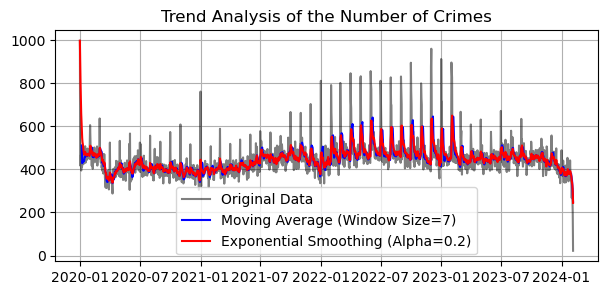

In [50]:
# Moving Average
window_size = 7  # Choose an appropriate window size
grouped_q5['Moving_Avg'] = grouped_q5['COUNT'].rolling(window=window_size).mean()

# Exponential Smoothing
alpha = 0.2  # Smoothing parameter
grouped_q5['Exp_Smooth'] = grouped_q5['COUNT'].ewm(alpha=alpha, adjust=False).mean()

# Plotting
plt.figure(figsize=(7, 3))
plt.plot(grouped_q5['DATE OCC'], grouped_q5['COUNT'], label='Original Data', color='black', alpha=0.5)
plt.plot(grouped_q5['DATE OCC'], grouped_q5['Moving_Avg'], label=f'Moving Average (Window Size={window_size})', color='blue')
plt.plot(grouped_q5['DATE OCC'], grouped_q5['Exp_Smooth'], label=f'Exponential Smoothing (Alpha={alpha})', color='red')

plt.xlabel('')
plt.ylabel('')
plt.title('Trend Analysis of the Number of Crimes')
plt.legend()
plt.grid(True)
plt.show()


In [51]:
# Assuming grouped_q5 is your DataFrame
window_size = 7  # Choose an appropriate window size
alpha = 0.2  # Smoothing parameter

# Create a base chart
base = alt.Chart(grouped_q5).properties(
    width=1000,
    height=200,
    title='Trend Analysis of the Number of Crimes'
)

# Plot the original data
line_original = base.mark_line(color='black', opacity=0.5).encode(
    x=alt.X('DATE OCC:T', title=''),
    y=alt.Y('COUNT:Q', title=''),
    tooltip=['DATE OCC:T', 'COUNT:Q'],
    color=alt.value('black'),
    strokeWidth=alt.value(1)
).properties(
    title='Trend Analysis of the Number of Crimes'
)

# Plot the moving average
line_moving_avg = base.mark_line(color='blue').encode(
    x=alt.X('DATE OCC:T', title=''),
    y=alt.Y('Moving_Avg:Q', title='', scale=alt.Scale(domain=[0, 1000])),  # Adjust the domain as needed
    color=alt.value('blue'),
    strokeWidth=alt.value(1),
    strokeDash=alt.value([5, 5])  # Add a dashed line style
).properties(
    title=f'Moving Average (Window Size={window_size})'
)

# Plot the exponential smoothing
line_exp_smooth = base.mark_line(color='red').encode(
    x=alt.X('DATE OCC:T', title=''),
    y=alt.Y('Exp_Smooth:Q', title='', scale=alt.Scale(domain=[0, 1000])),  # Adjust the domain as needed
    color=alt.value('red'),
    strokeWidth=alt.value(1),
    strokeDash=alt.value([5, 5])  # Add a dashed line style
).properties(
    title=f'Exponential Smoothing (Alpha={alpha})'
)

# Combine all the layers
line_original + line_exp_smooth + line_moving_avg

alt.LayerChart(...)

In [73]:
line_original

alt.Chart(...)

In [74]:
alt.vconcat(line_exp_smooth, line_moving_avg)

alt.VConcatChart(...)

### Seasonality Analysis: Investigate whether there are any seasonal patterns or cycles in the data. Seasonal decomposition techniques like seasonal decomposition of time series (STL) or seasonal-trend decomposition using LOESS (STL) can help in identifying and removing seasonal components from the data.

In [53]:
# Set 'DATE OCC' as the index of the DataFrame
grouped_q5.set_index('DATE OCC', inplace=True)

# Perform seasonal decomposition using STL
stl = STL(grouped_q5['COUNT'])
result = stl.fit()

In [54]:
# Convert the decomposition components to DataFrame
df_observed = pd.DataFrame({'DATE OCC': grouped_q5.index, 'Observed': result.observed})
df_trend = pd.DataFrame({'DATE OCC': grouped_q5.index, 'Trend': result.trend})
df_seasonal = pd.DataFrame({'DATE OCC': grouped_q5.index, 'Seasonal': result.seasonal})
df_resid = pd.DataFrame({'DATE OCC': grouped_q5.index, 'Residual': result.resid})

# Plot the decomposition components with Altair
observed_chart = alt.Chart(df_observed).mark_line(color='black', opacity=0.5).encode(
    x=alt.X('DATE OCC:T', title=''),
    y=alt.Y('Observed:Q', title='')
).properties(
    title='Observed',
    width=1000,
    height=200
)

trend_chart = alt.Chart(df_trend).mark_line(color='blue',opacity=0.5).encode(
    x=alt.X('DATE OCC:T', title=''),
    y=alt.Y('Trend:Q', title='')
).properties(
    title='Trend',
    width=1000,
    height=200
)

seasonal_chart = alt.Chart(df_seasonal).mark_line(color='red', opacity=0.5).encode(
    x=alt.X('DATE OCC:T', title=''),
    y=alt.Y('Seasonal:Q', title='')
).properties(
    title='Seasonal',
    width=1000,
    height=200
)

residual_chart = alt.Chart(df_resid).mark_line(color='green', opacity=0.5).encode(
    x=alt.X('DATE OCC:T', title=''),
    y=alt.Y('Residual:Q', title='')
).properties(
    title='Residual',
    width=1000,
    height=200
)

# Combine all charts
alt.vconcat(observed_chart, trend_chart, seasonal_chart, residual_chart).properties(
    title='Seasonal Decomposition of the Number of Crimes'
)


alt.VConcatChart(...)

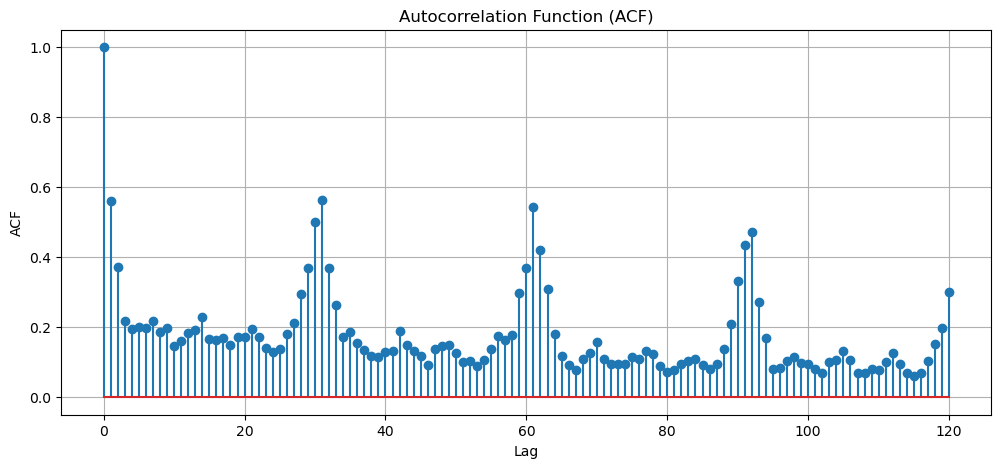

In [55]:
# Calculate autocorrelation function (ACF)
acf = sm.tsa.acf(grouped_q5['COUNT'], nlags=120)  # Adjust nlags as needed

# Plot the ACF
plt.figure(figsize=(12, 5))
plt.stem(acf)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()
